# Index Research Based on Shiller Dataset


## Purpose and Background
Purpose: evaluate the predictive power of major price and economic indicators on S&P 500 returns 

Dataset source: http://www.econ.yale.edu/~shisller/data.htm

+ Named as: FinancialMarketData.xlsx


## Import Packages, Import & Explore Data

In [59]:
# %% packages
# can use "conda info --envs" to check default environment in terminal

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# for datetime plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# more plotting
import seaborn as sns

# machine learning & numpy
import numpy as np
from sklearn import linear_model # for predictive model
from sklearn.model_selection import train_test_split #for splitting
from yellowbrick.regressor import ResidualsPlot

# XGBoost

# file export
import openpyxl

In [60]:
# %% import & explore data
df = pd.read_excel('SP500_Index_Research_FinancialMarketData.xlsx', 
                   sheet_name = "YearlyMacro")
print(df.dtypes)

DateFmt                float64
Price                  float64
Dividend               float64
Earnings               float64
CPI                    float64
DateFraction           float64
RateGS10               float64
RealSP500              float64
RealDividend           float64
RealEarnings           float64
CAPE                   float64
Source                  object
LastUpdated     datetime64[ns]
Date            datetime64[ns]
dtype: object


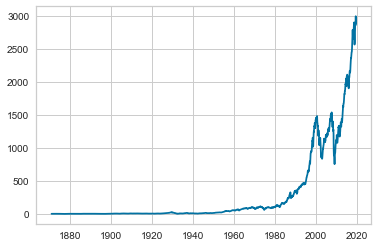

In [61]:
# plot data
# fix for using IPython/Spyder
# %matplotlib qt5
fig, ax  = plt.subplots()
ax.plot(df['DateFraction'],df['Price'])

# ax1 = ax.twinx()
# ax1.plot(summary['DGS10'], color = 'r')

## Hypothesis A: Predict S&P 500 10-yr Price Based on Macro Factors

Let:
+ y = target price 
+ e = adjusted earnings
+ r = 10-yr treasury rate 
+ g = growth rate

Hypothesize that returns follow:
$\begin{aligned}
y   = e / r * (1 + g)
\end{aligned}$

This is based on dividend discount model (assuming dividends are like earnings)

Now, create the necessary variables to test this:

In [62]:
# %% create columns to complete analysis

# future returns (dependent variable)
df['SP500FwdYr01'] = df['Price'].shift(-12) #next year
df['SP500FwdYr01Returns']  = df['SP500FwdYr01'] /df['Price'] - 1

df['SP500FwdYr10'] = df['Price'].shift(-120) #next 10 yrs
df['SP500FwdYr10Returns']  = (df['SP500FwdYr10'] /df['Price'])**(.1) - 1

# pick independent variables
df['InflationTrailing5yrFactor'] = df['CPI'] / df['CPI'].shift(60) #check previous 5 years
df['PERatio'] = df['Price'] / df['Earnings']
df['Earnings10yr'] = df['Earnings'].rolling(window = 120).mean()  # mean of last 10 yrs
df['Earnings10yrGrowthRate'] = (df['Earnings10yr']/df['Earnings10yr'].shift(120))**(.1)-1 # last 10 yrs 
# TODO try different growth rate
df['Earnings10yrAdj'] = df['Earnings10yr'] * (1+df['Earnings10yrGrowthRate'])**5 \
    * df['InflationTrailing5yrFactor']
df['PERatio10yrAdj'] =  df['Price'] / df['Earnings10yrAdj']

# such as target price 
df['Targetprice1yr']  = df['Earnings'] /(df['RateGS10']/100)
df['Targetprice1yrReturn'] = df['Targetprice1yr'] /df['Price']  -1  
df['Targetprice10yr']  = df['Earnings10yrAdj'] /(df['RateGS10']/100) \
    * (1+ df['Earnings10yrGrowthRate'])**10 # includes growth
df['Targetprice10yrReturn'] = (df['Targetprice10yr'] /df['Price'])**(.1)  -1 

#trim file
df = df.dropna()

#check results
print(df.head())

     DateFmt  Price  Dividend  Earnings       CPI  DateFraction  RateGS10  \
348  1900.01   6.10    0.2175      0.48  7.897091   1900.041667  3.150000   
349  1900.02   6.21    0.2250      0.48  7.992232   1900.125000  3.145833   
350  1900.03   6.26    0.2325      0.48  7.992232   1900.208333  3.141667   
351  1900.04   6.34    0.2400      0.48  7.992232   1900.291667  3.137500   
352  1900.05   6.04    0.2475      0.48  7.801942   1900.375000  3.133333   

      RealSP500  RealDividend  RealEarnings  ...  InflationTrailing5yrFactor  \
348  197.883703      7.055689     15.571177  ...                    1.202898   
349  199.053975      7.212101     15.385814  ...                    1.217390   
350  200.656664      7.452504     15.385814  ...                    1.217390   
351  203.220967      7.692907     15.385814  ...                    1.166667   
352  198.326872      8.126805     15.761076  ...                    1.123287   

       PERatio Earnings10yr Earnings10yrGrowthRate  Earn

### Plot Result Using This Formula

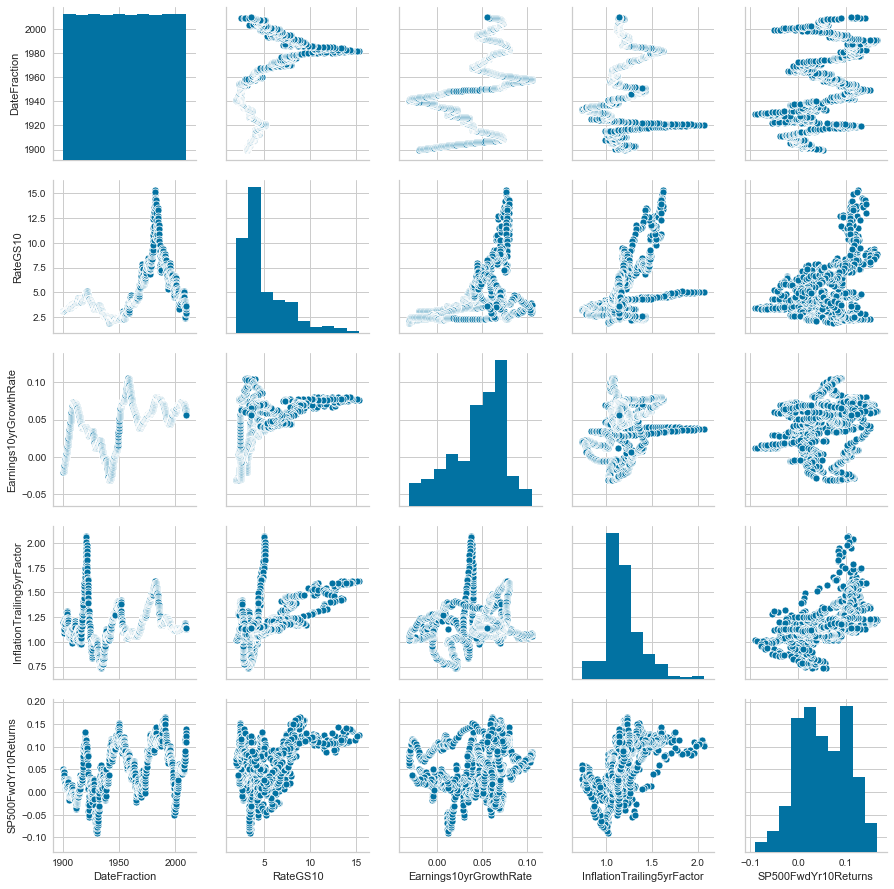

In [63]:
# %% 4 plot data
sns.pairplot(df[['DateFraction', 'RateGS10','Earnings10yrGrowthRate',
                 'InflationTrailing5yrFactor' ,
                 'SP500FwdYr10Returns']])


There are many relationships here, but nothing that clearly jumps out

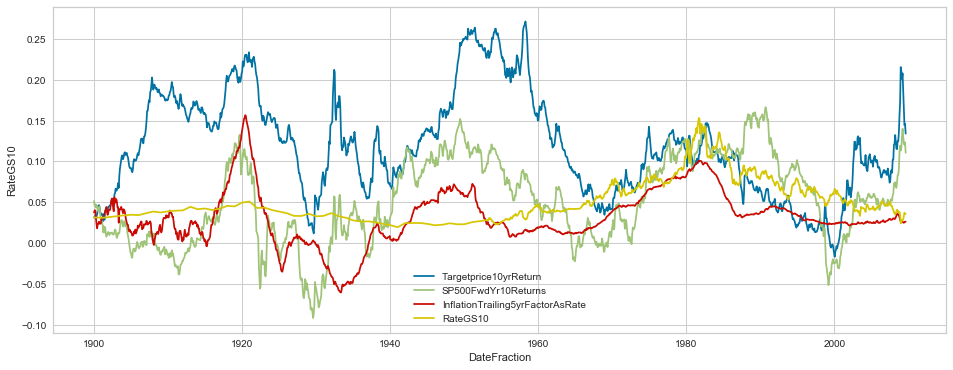

In [64]:
plt.figure(figsize=(16,6))
#fig3, ax3  = plt.subplots(figsize=(16, 6))
sns.lineplot(df['DateFraction'],df['Targetprice10yrReturn'], color = 'b')
#ax3 = plt.twinx()
sns.lineplot(df['DateFraction'],df['SP500FwdYr10Returns'], color = 'g')
sns.lineplot(df['DateFraction'],df['InflationTrailing5yrFactor']**.2-1, color = 'r')
sns.lineplot(df['DateFraction'],df['RateGS10']/100, color = 'y')
plt.legend(labels=['Targetprice10yrReturn','SP500FwdYr10Returns',
                    'InflationTrailing5yrFactorAsRate', 'RateGS10' ])


The blue estimated line is not a good fit for the green actual returns as there is a large spread between the the blue and green lines

### Export Data for Potential Further Analysis

In [65]:
# export data
df.to_excel('SP500_Index_Research_Results.xlsx', sheet_name = 'sheet1',)


## Hypothesis B: Use Linear Model to Predict Future 10-yr Factors

In [66]:
#prep data
X_all = df.loc[:,['DateFraction','PERatio10yrAdj',
             'InflationTrailing5yrFactor', 'RateGS10']]

selected = ['PERatio10yrAdj',
             'InflationTrailing5yrFactor', 'RateGS10']

X_all_selected = X_all[selected]

y_all = df.loc[:,'SP500FwdYr10Returns']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

X_train_selected = X_train[selected]
X_test_selected = X_test[selected]

In [67]:
#train classifier
clf = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train_selected, y_train)

params = clf.get_params(deep=True)

#evaluate on test
print("default (R^2) score:" + np.array2string(clf.score(X_test_selected,y_test)))
print("intercept: " + np.array2string(clf.intercept_))
print("coefficients: " + np.array2string(clf.coef_))

default (R^2) score:0.39750241
intercept: -0.03185082
coefficients: [-0.00306141  0.09323249  0.00269951]


In [68]:
#predict using classifier
y_pred_B = clf.predict(X_all_selected)

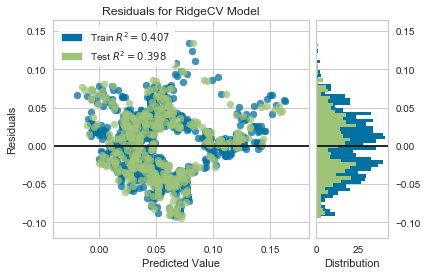

In [69]:
# residual plots
visualizer = ResidualsPlot(clf)
visualizer.fit(X_train_selected, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_selected, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

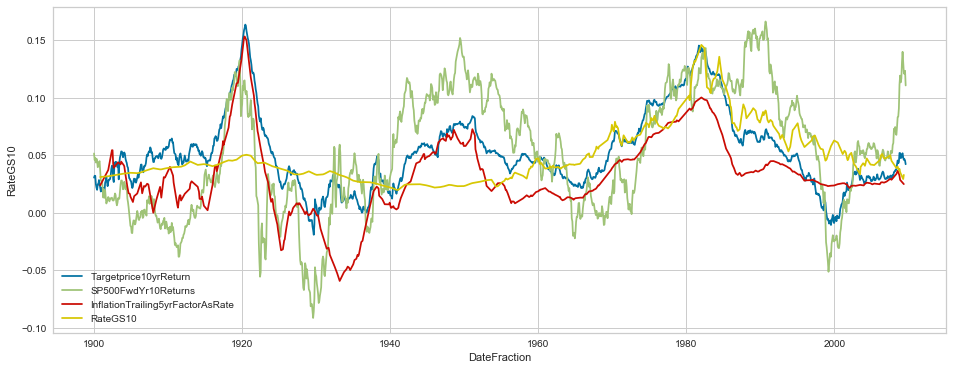

In [70]:
#plot all results, including train & test
plt.figure(figsize=(16,6))
#fig3, ax3  = plt.subplots(figsize=(16, 6))

sns.lineplot(X_all['DateFraction'],y_pred_B, color = 'b')
#ax3 = plt.twinx()
sns.lineplot(X_all['DateFraction'],y_all, color = 'g')
sns.lineplot(X_test['DateFraction'],X_all['InflationTrailing5yrFactor']**.2-1, color = 'r')
sns.lineplot(X_test['DateFraction'],X_all['RateGS10']/100, color = 'y')
plt.legend(labels=['Targetprice10yrReturn','SP500FwdYr10Returns',
                    'InflationTrailing5yrFactorAsRate', 'RateGS10' ])

There is still a (smaller) spread between green and blue lines

## Conclusion
Both hypotheses (A: simple relationship using macro factors such as earnings growth, rates and inflation and B: linear model) do not sufficiently explain rolling 10-year market returns

## Future Work

Hyphothesis C: Use XGBoost for Non-Linear Relationships

Incorporate Corporate bonds